## Importing Libraries

In [ ]:
# Import necessary libraries
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.signal import resample
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchinfo import summary


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


## Data Preparation

In [ ]:
# Load the audio dataset
audio_path = 'original_book_audio.mp3'
audio, sr = librosa.load(audio_path, sr=16000)
print(f"Total duration of audio (in seconds): {len(audio) / sr:.2f} seconds")

Total duration of audio (in seconds): 614.85 seconds


In [ ]:
print(sr)

16000


In [ ]:
audio.max()

np.float32(0.21750432)

In [ ]:
audio.min()

np.float32(-0.21994011)

In [ ]:
# Split the audio into 1-second chunks
chunk_size = sr  # 1 second = 22050 samples for 16kHz
samples = [audio[i:i + chunk_size] for i in range(0, len(audio), chunk_size) if len(audio[i:i + chunk_size]) == chunk_size]
print(f"Total number of 1-second samples: {len(samples)}")

Total number of 1-second samples: 614


In [ ]:
# Function to increase pitch
def increase_pitch(data, sr, n_steps=12.0):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Prepare X and Y datasets
X = np.array(samples)
Y = np.array([increase_pitch(sample, sr) for sample in X])


sf.write('pitched_book_audio.wav', np.concatenate(Y), sr)
print("Y labels Datasets saved: 'pitched_book_audio.wav'")


Y labels Datasets saved: 'pitched_book_audio.wav'


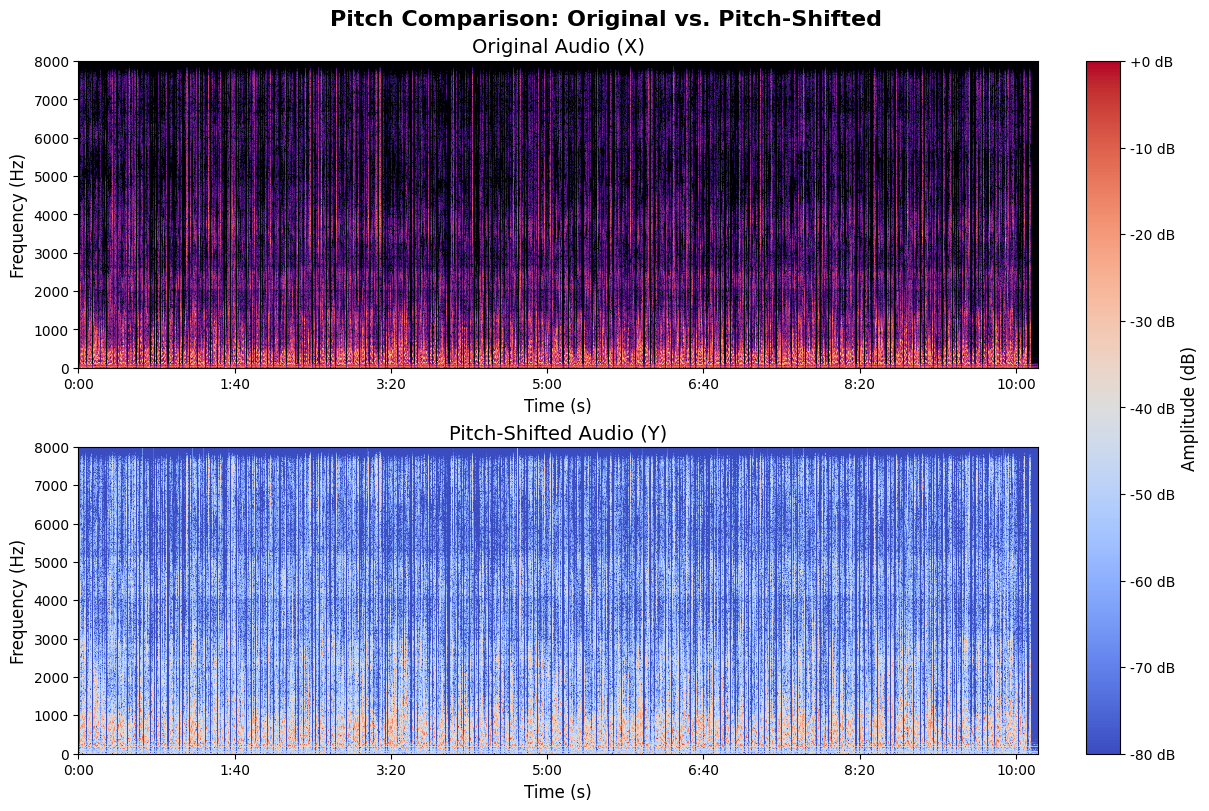

In [ ]:
# Function to plot spectrograms
def plot_spectrogram(data, sr, title, ax, cmap="viridis"):
    """
    Plot the spectrogram for given audio data.
    """
    # Compute the spectrogram
    S = librosa.stft(data)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Display the spectrogram
    img = librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz", ax=ax, cmap=cmap)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    return img

# Plot the spectrograms for X and Y
def plot_pitch_comparison(X, Y, sr):
    """
    Plot a comparison of spectrograms for original (X) and pitch-shifted (Y) audio.
    """
    # Ensure X and Y are 1D (combine if needed)
    X_combined = np.concatenate(X)
    Y_combined = np.concatenate(Y)

    # Create a figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)
    fig.suptitle("Pitch Comparison: Original vs. Pitch-Shifted", fontsize=16, fontweight="bold")

    # Plot original audio spectrogram
    plot_spectrogram(X_combined, sr, "Original Audio (X)", axs[0], cmap="magma")

    # Plot pitch-shifted audio spectrogram
    img = plot_spectrogram(Y_combined, sr, "Pitch-Shifted Audio (Y)", axs[1], cmap="coolwarm")

    # Add colorbar
    cbar = fig.colorbar(img, ax=axs, format="%+2.0f dB")
    cbar.set_label("Amplitude (dB)", fontsize=12)

    plt.show()

# Call the function to plot
plot_pitch_comparison(X, Y, sr)

In [ ]:
# Normalize the data
def normalize(audio_batch):
    return audio_batch / np.max(np.abs(audio_batch))

X = normalize(X)
Y = normalize(Y)


In [ ]:
# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")


Train samples: 491, Validation samples: 61, Test samples: 62


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(AudioDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(AudioDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(AudioDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)


## Model Architecture

In [ ]:
class ConvLSTMBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLSTMBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_lstm=False):
        super(EncoderBlock, self).__init__()
        if use_lstm:
            self.block = ConvLSTMBlock(in_channels, out_channels)
        else:
            self.block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block(x)
        p = self.pool(x)
        return x, p


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        # Concatenate along channel dimension
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        
        return x


class UNet1D(nn.Module):
    def __init__(self, input_channels=1, device=None):
        super(UNet1D, self).__init__()
        self.feedback = None
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.use_feedback = True

        # Encoder
        self.enc1 = EncoderBlock(input_channels, 64, use_lstm=True)
        self.enc2 = EncoderBlock(64, 128, use_lstm=True)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvLSTMBlock(512, 512)

        # Decoder
        self.dec1 = DecoderBlock(512, 512, 512)
        self.dec2 = DecoderBlock(512, 256, 256)
        self.dec3 = DecoderBlock(256, 128, 128)
        self.dec4 = DecoderBlock(128, 64, 64)

        # Output layer
        self.final_conv = nn.Conv1d(64, input_channels, kernel_size=1)

        # Move the model to the specified device
        self.to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        if self.use_feedback and self.feedback is not None:
            x = x + self.feedback  # Add feedback

        # Encoder
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)

        out = torch.sigmoid(self.final_conv(d4))
        if self.use_feedback:
            # Store feedback for the next forward pass
            self.feedback = out 

        return out


if __name__ == "__main__":
    # Test the 1D U-Net architecture
    # Batch size, Channels, Length
    input_shape = (1, 1, 1024)  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model
    model = UNet1D(input_channels=1, device=device)

    # Generate random input tensor
    x = torch.randn(input_shape).to(device)

    # Forward pass (Disable feedback for testing)
    model.use_feedback = False  
    output = model(x)
    print("Output shape:", output.shape)

    # Print model summary
    print(summary(model, input_size=input_shape, device=device))

Output shape: torch.Size([1, 1, 1024])
Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 1, 1024]              --
├─EncoderBlock: 1-1                      [1, 64, 1024]             --
│    └─ConvLSTMBlock: 2-1                [1, 64, 1024]             --
│    │    └─Conv1d: 3-1                  [1, 64, 1024]             256
│    │    └─BatchNorm1d: 3-2             [1, 64, 1024]             128
│    └─MaxPool1d: 2-2                    [1, 64, 512]              --
├─EncoderBlock: 1-2                      [1, 128, 512]             --
│    └─ConvLSTMBlock: 2-3                [1, 128, 512]             --
│    │    └─Conv1d: 3-3                  [1, 128, 512]             24,704
│    │    └─BatchNorm1d: 3-4             [1, 128, 512]             256
│    └─MaxPool1d: 2-4                    [1, 128, 256]             --
├─EncoderBlock: 1-3                      [1, 256, 256]             --
│    └─ConvBlock: 2-5                  

## Training & Validation

In [ ]:
# Signal-to-Noise Ratio (SNR) Loss
def snr_loss(y_pred, y_true):
    signal_power = torch.sum(y_true ** 2, dim=-1)
    noise_power = torch.sum((y_true - y_pred) ** 2, dim=-1)
    snr = 10 * torch.log10(signal_power / (noise_power + 1e-6))
    return -torch.mean(snr)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training Loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        X_batch = X_batch.unsqueeze(1)
        Y_batch = Y_batch.unsqueeze(1)
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = snr_loss(predictions, Y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)
            Y_batch = Y_batch.unsqueeze(1)
            
            predictions = model(X_batch)
            loss = snr_loss(predictions, Y_batch)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/20, Train Loss: 8.5200, Val Loss: 11.3464
Epoch 2/20, Train Loss: 4.0910, Val Loss: 3.0977
Epoch 3/20, Train Loss: 1.6171, Val Loss: 1.2224
Epoch 4/20, Train Loss: 0.8114, Val Loss: 0.6485
Epoch 5/20, Train Loss: 0.4053, Val Loss: 0.4349
Epoch 6/20, Train Loss: 0.2504, Val Loss: 0.2941
Epoch 7/20, Train Loss: 0.1816, Val Loss: 0.1813
Epoch 8/20, Train Loss: 0.1351, Val Loss: 0.1513
Epoch 9/20, Train Loss: 0.0981, Val Loss: 0.0861
Epoch 10/20, Train Loss: 0.0706, Val Loss: 0.0553
Epoch 11/20, Train Loss: 0.0634, Val Loss: 0.0323
Epoch 12/20, Train Loss: 0.0471, Val Loss: 0.0385
Epoch 13/20, Train Loss: 0.0346, Val Loss: 0.0237
Epoch 14/20, Train Loss: 0.0274, Val Loss: 0.0183
Epoch 15/20, Train Loss: 0.0220, Val Loss: 0.0125
Epoch 16/20, Train Loss: 0.0182, Val Loss: 0.0096
Epoch 17/20, Train Loss: 0.0153, Val Loss: 0.0082
Epoch 18/20, Train Loss: 0.0128, Val Loss: 0.0058
Epoch 19/20, Train Loss: 0.0110, Val Loss: 0.0050
Epoch 20/20, Train Loss: 0.0093, Val Loss: 0.0044


## Saving Model

In [ ]:
# Save the model and optimizer states
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, "book_model_checkpoint.pth")

## Prediction / Results (Training data)

In [ ]:
# Generate predictions on training data
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device).unsqueeze(1)
        preds = model(X_batch).squeeze(1).cpu().numpy()
        predictions.extend(preds)

# Save predictions as a single .wav file
predictions = np.concatenate(predictions)
sf.write('predicted_book_audio.wav', predictions, sr)
print("Predicted output saved as 'predicted_book_audio.wav'")


Predicted output saved as 'predicted_book_audio.wav'


In [ ]:
# Function to plot spectrogram
def plot_spectrogram(data, sr, title, cmap="viridis"):
    """
    Plot the spectrogram for given audio data.
    """
    # Compute the spectrogram
    S = librosa.stft(data)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Create the plot
    plt.figure(figsize=(12, 6))
    img = librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz", cmap=cmap)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(img, format="%+2.0f dB")
    cbar.set_label("Amplitude (dB)", fontsize=12)

    plt.tight_layout()
    plt.show()

# Load the audio file
audio_path = "predicted_book_audio"
data, sr = librosa.load(audio_path, sr=None)

# Plot the spectrogram for the audio file
plot_spectrogram(data, sr, title="Spectrogram of Predicted Audio", cmap="magma")